# Introduction to `nelpy` EpochArrays

In `nelpy`, all the core data objects (`EpochArray`, `AnalogSignalArray`, `SpiketrainArray`, `BinnedSpiketrainArray`, ...) have an associated and underlying `EpochArray`, including `EpochArray` itself (more on this later).

#### What is an Epoch?
An Epoch is simply a time interval. More spcifically, epochs in `nelpy` are half open intervals $I=[a, b)$ measured in seconds. The `EpochArray` object then defines a collection of epochs, along with common operations and transformations that can be performed on them.

#### What are EpochArrays used for?
`EpochArray`s are fundamental to nelpy, because they define when data is defined. For example, if we record action potentials (or spikes) from a single neuron, and observe spikes at times
$$\text{spike_times} = 1,3,4,5, 9, 18 \quad \text{(seconds)}$$
then in order to compute even the simplest estimates such as average firing rate, we need to know _how long did we record for_? If we had observed the above spike times over a period of 1 minute, for example, the firing rate estimate would be 6 spikes / 60 seconds = 0.1 Hz. However, if we observed the neuron only for $I=[0,20)$ then the etimate of the firing rate would be 6 spikes / 20 seconds = 0.3 Hz instead. This is where `EpochArrays` come in handy, in that they define **when the observed data is valid**.

Another use case for `EpochArrays` is to easily extract subsets of data for further analysis. For example, if we have LFP (local field potential) data on $I_{LFP}=[0,60)$, and we have animal run speed estimates on $I_{speed} = [3,27)$, and we are interested in calculating the average LFP _only during periods when the animal was running faster than some threshold_, then we can easily determine those epochs within $I_{speed}$ that satisfies our criteria and store them in a single `EpochArray`, and then we can directly index LFP with this new `EpochArray` to return the restricted subset of LFP data. 

**Disclaimer:** We really need a few more objects to make the above example clear and convincing, but conceptually at least this type of operation is very common, and is made almost trivial with the use of `EpochArrays`.

#### Support vs domain
While technically a mathematical "support" of a function refers to the region on its domain where the function is non-zero, we use the term a little more loosely here, in that a `nelpy` object's support is the region where the object (data) is defined. However, a related concept is that of its _domain_, which specifies where the object (data) _could be defined_. By default, all objects have a domain of $\Omega = (-\infty, \infty)$. The domain is necessary when talking about complements, so that in the default domain, the complement of $[a, b)$ is $(-\infty, a) \cup [b, \infty)$.


### Some set-theoretic operations supported by EpochArrays

Recall that the default domain for any `nelpy` object is $\Omega = (-\infty, \infty)$. Several set-theoretic operations are available in `nelpy`, namely:
 * Set difference: $$A - B := \{x \in \Omega : x\in A, x \notin B\}$$ `nelpy: A - B`
 * Set intersection $$A \cap B := \{x \in \Omega : x\in A, x\in B\}$$ `nelpy: A & B` or `A[B]`
 * Set union $$A \cup B := \{x \in \Omega : x\in A \text{ or } x\in B\}$$ `nelpy: A | B`
 * Set complement $$A^{\text{c}} := \{x \in \Omega : x \notin A\}$$ `nelpy: ~A`
 * Set merger $$\text{merge}(A) := \{x \in \Omega : x \in A\}$$ `nelpy: A.merge()`
 * Set addition $$A + B := \{\omega : \omega \in A \text{ or } \omega \in B \}$$ `nelpy: A + B`

where $\{x\}$ are samples, and $\{\omega\}$ are epochs.

### Importing nelpy

In [1]:
import nelpy as nel

### Interacting with EpochArrays

Frequently, `EpochArrays` will underlie other `nelpy` objects, and you won't need to worry about interacting with them too much. However, there are cases where direct manipulation and / or interaction can be very useful.

First of all, all `nelpy` objects have human-readable `__repr__` methods that make it convenient to get a quick summary (and insight) of the data object. Let's take a closer look.

We start by creating an `EpochArray` containing three disjoint intervals, namely $[0,3) \cup [5,6) \cup [10,15)$:

In [2]:
ep = nel.EpochArray([[0,3], [5,6], [10,15]])

which we can look at either by calling `print()` on the `EpochArray` object, or by evaluating `ep` in the REPL.

In [3]:
print(ep)

<EpochArray at 0x7fbabbbc7a90: 3 epochs> of duration 9 seconds


Here we can see that we received immediate feedback, namely that there are 3 epochs inside the `EpochArray`, and that the total duration of those epochs is 9 seconds.

Nelpy makes it easy to read durations of various magnitudes, and would print "1:20 minutes" for a duration of 80 seconds, and "2:13:20 hours" for a duration of 8000 seconds, for example.

#TODO: add examples of operators, union, intersection, iteration, slicing, indexing, class attributes, plotting, ...

### Now we add interactive widgets to explore transformations of EpochArrays

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import warnings

import nelpy.plotting as npl

from ipywidgets import interact, interactive, fixed, interact_manual

%matplotlib inline

warnings.filterwarnings("ignore")

In [5]:
times = np.array([[1.0, 3.0],
                  [4.0, 8.0],
                  [12.0, 13.0],
                  [20.0, 25.0],
                  [1.0, 5.0],
                  [6.0, 7.0],
                  [15.0, 18.0],
                  [30.0, 35.0]])
ep1 = nel.EpochArray(times, domain=nel.EpochArray([0, 50]))

In [6]:
(ep1 - ep).time

array([[  3.,   5.],
       [  6.,   8.],
       [ 15.,  18.],
       [ 20.,  25.],
       [ 30.,  35.]])

In [7]:
(ep1 + 5).domain

<EpochArray at 0x7fbabbb56278: 1 epoch> of duration 50 seconds

In [8]:
def epplt(epoch, expand=0, rshift=0, lshift=0, merge=False, complement=False):
    fig = plt.figure(figsize=(16,1))
    ax = fig.add_subplot(111)
    
    epoch = epoch + expand
    epoch = epoch >> rshift
    epoch = epoch << lshift
    if merge:
        epoch = epoch.merge()
    if complement:
        epoch = ~epoch
    ax = npl.epochplot(epoch)
    npl.epochplot(~epoch, color='r')
    ax.set_xlim(epoch.domain.start, epoch.domain.stop)
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top(ax)

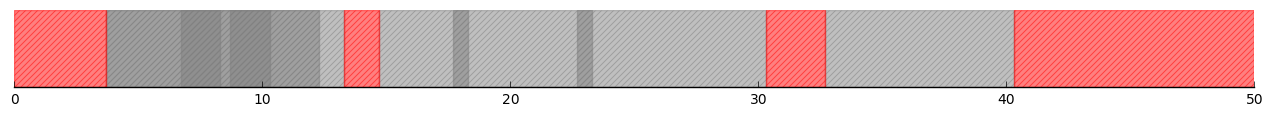

In [9]:
interact(epplt, epoch=fixed(ep1), expand=(-0.5,2.5,0.1), rshift=(0,12.5,0.5), lshift=(0,12,0.5), merge=False, complement=False);

In [12]:
ep1.time

array([[  1.,   3.],
       [  1.,   5.],
       [  4.,   8.],
       [  6.,   7.],
       [ 12.,  13.],
       [ 15.,  18.],
       [ 20.,  25.],
       [ 30.,  35.]])

In [13]:
(ep1 + 2).time

array([[ -1.,   5.],
       [ -1.,   7.],
       [  2.,  10.],
       [  4.,   9.],
       [ 10.,  15.],
       [ 13.,  20.],
       [ 18.,  27.],
       [ 28.,  37.]])

Recall that the default domain for any `nelpy` object is $\Omega = (-\infty, \infty)$. Several set-theoretic operations are available in `nelpy`, namely:
 * Set difference: $$A - B := \{x \in \Omega : x\in A, x \notin B\}$$ `nelpy: A - B`
 * Set intersection $$A \cap B := \{x \in \Omega : x\in A, x\in B\}$$ `nelpy: A & B` or `A[B]`
 * Set union $$A \cup B := \{x \in \Omega : x\in A \text{ or } x\in B\}$$ `nelpy: A | B`
 * Set complement $$A^{\text{c}} := \{x \in \Omega : x \notin A\}$$ `nelpy: ~A`
 * Set merger $$\text{merge}(A) := \{x \in \Omega : x \in A\}$$ `nelpy: A.merge()`
 * Set addition $$A + B := \{\omega : \omega \in A \text{ or } \omega \in B \}$$ `nelpy: A + B`

where $\{x\}$ are samples, and $\{\omega\}$ are epochs.